# Model to Predict Housing Prices in Austin, TX

This project will use a Long Short-Term Memory neural network model.

The dataset includes house sale prices, unemployment rates, median household income, city population and mortgage interest rates from Feb. 2008 to Dec 2019

In [25]:
import pandas as pd
from matplotlib import pyplot
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense

from numpy import concatenate
from math import sqrt
from sklearn.metrics import mean_squared_error



In [32]:
df = pd.read_csv('austin_data.csv')
df.head()

,Date,Price,Unemployment,Income,Population,Interest
0,2/29/08,185000,3.8,59221,1268000,5.92
1,3/31/08,190000,3.8,59221,1268000,5.92
2,4/30/08,191500,3.4,59221,1268000,5.92
3,5/31/08,198250,3.9,59221,1268000,5.92
4,6/30/08,197500,4.4,59221,1268000,5.92


# Data Preprocessing

Set the date column to pandas datetime format and make it the index.

In [33]:
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df.head()

,Price,Unemployment,Income,Population,Interest
Date,,,,,
2008-02-29,185000,3.8,59221,1268000,5.92
2008-03-31,190000,3.8,59221,1268000,5.92
2008-04-30,191500,3.4,59221,1268000,5.92
2008-05-31,198250,3.9,59221,1268000,5.92
2008-06-30,197500,4.4,59221,1268000,5.92


Plot each feature over time.

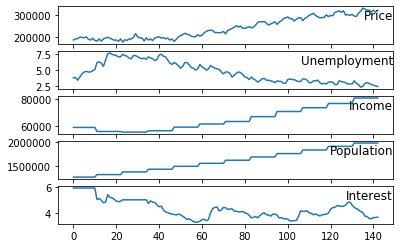

In [34]:
values = df.values
# specify columns to plot
groups = [0, 1, 2, 3, 4]
i = 1
# plot each column
pyplot.figure()
for group in groups:
	pyplot.subplot(len(groups), 1, i)
	pyplot.plot(values[:, group])
	pyplot.title(df.columns[group], y=0.5, loc='right')
	i += 1
pyplot.show()

Convert the feature series to supervised learning.

In [35]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[6, 7, 8, 9]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)   var1(t)
1   0.062616   0.277778   0.137921        0.0        1.0  0.093924
2   0.093924   0.277778   0.137921        0.0        1.0  0.103316
3   0.103316   0.203704   0.137921        0.0        1.0  0.145582
4   0.145582   0.296296   0.137921        0.0        1.0  0.140886
5   0.140886   0.388889   0.137921        0.0        1.0  0.125232


Split the data into train and test sets.

In [49]:
values = reframed.values
n_train_months = 8 * 12
train = values[:n_train_months, :]
test = values[n_train_months:, :]

train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(96, 1, 5) (96,) (46, 1, 5) (46,)


# Building the model

Fit the LSTM model that uses 50 epochs, a batch size of 72 and two hidden layers. Then plot the loss and validation loss.

Train on 96 samples, validate on 46 samples
Epoch 1/50
 - 1s - loss: 0.2312 - val_loss: 0.7330
Epoch 2/50
 - 0s - loss: 0.2168 - val_loss: 0.7151
Epoch 3/50
 - 0s - loss: 0.2034 - val_loss: 0.6966
Epoch 4/50
 - 0s - loss: 0.1900 - val_loss: 0.6780
Epoch 5/50
 - 0s - loss: 0.1779 - val_loss: 0.6596
Epoch 6/50
 - 0s - loss: 0.1667 - val_loss: 0.6411
Epoch 7/50
 - 0s - loss: 0.1569 - val_loss: 0.6227
Epoch 8/50
 - 0s - loss: 0.1479 - val_loss: 0.6042
Epoch 9/50
 - 0s - loss: 0.1398 - val_loss: 0.5859
Epoch 10/50
 - 0s - loss: 0.1342 - val_loss: 0.5679
Epoch 11/50
 - 0s - loss: 0.1302 - val_loss: 0.5503
Epoch 12/50
 - 0s - loss: 0.1273 - val_loss: 0.5332
Epoch 13/50
 - 0s - loss: 0.1257 - val_loss: 0.5166
Epoch 14/50
 - 0s - loss: 0.1244 - val_loss: 0.5006
Epoch 15/50
 - 0s - loss: 0.1229 - val_loss: 0.4848
Epoch 16/50
 - 0s - loss: 0.1213 - val_loss: 0.4694
Epoch 17/50
 - 0s - loss: 0.1200 - val_loss: 0.4543
Epoch 18/50
 - 0s - loss: 0.1185 - val_loss: 0.4393
Epoch 19/50
 - 0s - loss: 0.1

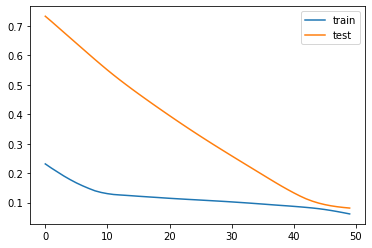

In [50]:
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')


history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

The train and test sets took a long time to converge. Next, calculated RMSE. The predictions and actual targets needed to be inverse scaled.

In [52]:

yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

ainv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 14427.645


This version is trained on ten years of data.

In [56]:

values = reframed.values
n_train_months = 10 * 12
train = values[:n_train_months, :]
test = values[n_train_months:, :]

train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(120, 1, 5) (120,) (22, 1, 5) (22,)


Train on 120 samples, validate on 22 samples
Epoch 1/50
 - 1s - loss: 0.3558 - val_loss: 0.9392
Epoch 2/50
 - 0s - loss: 0.3409 - val_loss: 0.9169
Epoch 3/50
 - 0s - loss: 0.3254 - val_loss: 0.8947
Epoch 4/50
 - 0s - loss: 0.3109 - val_loss: 0.8725
Epoch 5/50
 - 0s - loss: 0.2976 - val_loss: 0.8505
Epoch 6/50
 - 0s - loss: 0.2853 - val_loss: 0.8286
Epoch 7/50
 - 0s - loss: 0.2740 - val_loss: 0.8069
Epoch 8/50
 - 0s - loss: 0.2643 - val_loss: 0.7855
Epoch 9/50
 - 0s - loss: 0.2562 - val_loss: 0.7647
Epoch 10/50
 - 0s - loss: 0.2495 - val_loss: 0.7447
Epoch 11/50
 - 0s - loss: 0.2442 - val_loss: 0.7256
Epoch 12/50
 - 0s - loss: 0.2396 - val_loss: 0.7072
Epoch 13/50
 - 0s - loss: 0.2354 - val_loss: 0.6893
Epoch 14/50
 - 0s - loss: 0.2311 - val_loss: 0.6721
Epoch 15/50
 - 0s - loss: 0.2268 - val_loss: 0.6552
Epoch 16/50
 - 0s - loss: 0.2225 - val_loss: 0.6386
Epoch 17/50
 - 0s - loss: 0.2182 - val_loss: 0.6222
Epoch 18/50
 - 0s - loss: 0.2139 - val_loss: 0.6059
Epoch 19/50
 - 0s - loss: 0.

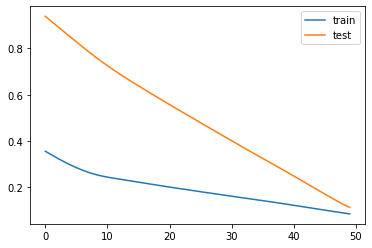

In [57]:

model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [58]:

yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 19689.800


This version is trained on ten years of data with 100 epochs.

(120, 1, 5) (120,) (22, 1, 5) (22,)
Train on 120 samples, validate on 22 samples
Epoch 1/100
 - 7s - loss: 0.3769 - val_loss: 0.9391
Epoch 2/100
 - 0s - loss: 0.3611 - val_loss: 0.9178
Epoch 3/100
 - 0s - loss: 0.3458 - val_loss: 0.8970
Epoch 4/100
 - 0s - loss: 0.3310 - val_loss: 0.8754
Epoch 5/100
 - 0s - loss: 0.3159 - val_loss: 0.8537
Epoch 6/100
 - 0s - loss: 0.3016 - val_loss: 0.8320
Epoch 7/100
 - 0s - loss: 0.2883 - val_loss: 0.8104
Epoch 8/100
 - 0s - loss: 0.2761 - val_loss: 0.7888
Epoch 9/100
 - 0s - loss: 0.2647 - val_loss: 0.7674
Epoch 10/100
 - 0s - loss: 0.2544 - val_loss: 0.7461
Epoch 11/100
 - 0s - loss: 0.2461 - val_loss: 0.7254
Epoch 12/100
 - 0s - loss: 0.2388 - val_loss: 0.7051
Epoch 13/100
 - 0s - loss: 0.2326 - val_loss: 0.6852
Epoch 14/100
 - 0s - loss: 0.2276 - val_loss: 0.6661
Epoch 15/100
 - 0s - loss: 0.2233 - val_loss: 0.6475
Epoch 16/100
 - 0s - loss: 0.2190 - val_loss: 0.6294
Epoch 17/100
 - 0s - loss: 0.2147 - val_loss: 0.6118
Epoch 18/100
 - 0s - loss: 

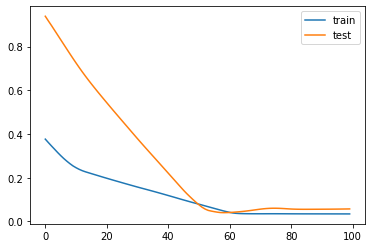

Test RMSE: 0.068


In [130]:
# split into train and test sets
values = reframed.values
n_train_months = 10 * 12
train = values[:n_train_months, :]
test = values[n_train_months:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=100, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)


In [ ]:
This version adds an extra hidden layer with 50 epochs.

(120, 1, 5) (120,) (22, 1, 5) (22,)
Train on 120 samples, validate on 22 samples
Epoch 1/50
 - 4s - loss: 0.3127 - val_loss: 0.7588
Epoch 2/50
 - 0s - loss: 0.2851 - val_loss: 0.7224
Epoch 3/50
 - 0s - loss: 0.2586 - val_loss: 0.6854
Epoch 4/50
 - 0s - loss: 0.2339 - val_loss: 0.6484
Epoch 5/50
 - 0s - loss: 0.2121 - val_loss: 0.6111
Epoch 6/50
 - 0s - loss: 0.1941 - val_loss: 0.5742
Epoch 7/50
 - 0s - loss: 0.1807 - val_loss: 0.5386
Epoch 8/50
 - 0s - loss: 0.1721 - val_loss: 0.5048
Epoch 9/50
 - 0s - loss: 0.1659 - val_loss: 0.4730
Epoch 10/50
 - 0s - loss: 0.1603 - val_loss: 0.4426
Epoch 11/50
 - 0s - loss: 0.1555 - val_loss: 0.4138
Epoch 12/50
 - 0s - loss: 0.1511 - val_loss: 0.3867
Epoch 13/50
 - 0s - loss: 0.1472 - val_loss: 0.3611
Epoch 14/50
 - 0s - loss: 0.1434 - val_loss: 0.3369
Epoch 15/50
 - 0s - loss: 0.1392 - val_loss: 0.3135
Epoch 16/50
 - 0s - loss: 0.1348 - val_loss: 0.2909
Epoch 17/50
 - 0s - loss: 0.1305 - val_loss: 0.2691
Epoch 18/50
 - 0s - loss: 0.1262 - val_loss:

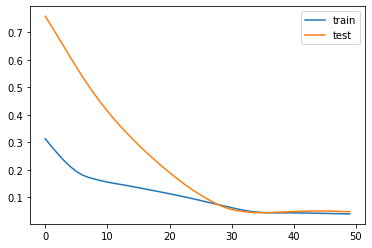

Test RMSE: 0.055


In [131]:
# split into train and test sets
values = reframed.values
n_train_months = 10 * 12
train = values[:n_train_months, :]
test = values[n_train_months:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(5))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)


This version is the same as above but uses a batch size of 24.

(120, 1, 5) (120,) (22, 1, 5) (22,)
Train on 120 samples, validate on 22 samples
Epoch 1/50
 - 5s - loss: 0.3041 - val_loss: 0.8893
Epoch 2/50
 - 0s - loss: 0.2861 - val_loss: 0.8457
Epoch 3/50
 - 0s - loss: 0.2732 - val_loss: 0.8061
Epoch 4/50
 - 0s - loss: 0.2625 - val_loss: 0.7700
Epoch 5/50
 - 0s - loss: 0.2522 - val_loss: 0.7354
Epoch 6/50
 - 0s - loss: 0.2416 - val_loss: 0.7008
Epoch 7/50
 - 0s - loss: 0.2315 - val_loss: 0.6670
Epoch 8/50
 - 0s - loss: 0.2214 - val_loss: 0.6331
Epoch 9/50
 - 0s - loss: 0.2112 - val_loss: 0.5992
Epoch 10/50
 - 0s - loss: 0.2013 - val_loss: 0.5650
Epoch 11/50
 - 0s - loss: 0.1911 - val_loss: 0.5301
Epoch 12/50
 - 0s - loss: 0.1810 - val_loss: 0.4946
Epoch 13/50
 - 0s - loss: 0.1706 - val_loss: 0.4580
Epoch 14/50
 - 0s - loss: 0.1599 - val_loss: 0.4205
Epoch 15/50
 - 0s - loss: 0.1490 - val_loss: 0.3823
Epoch 16/50
 - 0s - loss: 0.1378 - val_loss: 0.3434
Epoch 17/50
 - 0s - loss: 0.1263 - val_loss: 0.3040
Epoch 18/50
 - 0s - loss: 0.1145 - val_loss:

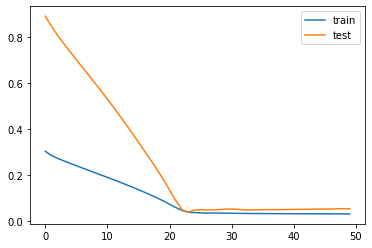

Test RMSE: 0.068


In [132]:
# split into train and test sets
values = reframed.values
n_train_months = 10 * 12
train = values[:n_train_months, :]
test = values[n_train_months:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(5))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=24, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

This model uses 25 nodes, three hidden layers, 50 epochs, and a batch size of 10

(120, 1, 5) (120,) (22, 1, 5) (22,)
Train on 120 samples, validate on 22 samples
Epoch 1/50
 - 4s - loss: 0.3733 - val_loss: 0.8575
Epoch 2/50
 - 0s - loss: 0.2506 - val_loss: 0.7027
Epoch 3/50
 - 0s - loss: 0.1980 - val_loss: 0.5965
Epoch 4/50
 - 0s - loss: 0.1821 - val_loss: 0.5172
Epoch 5/50
 - 0s - loss: 0.1635 - val_loss: 0.4467
Epoch 6/50
 - 0s - loss: 0.1418 - val_loss: 0.3767
Epoch 7/50
 - 0s - loss: 0.1173 - val_loss: 0.2998
Epoch 8/50
 - 0s - loss: 0.0921 - val_loss: 0.2176
Epoch 9/50
 - 0s - loss: 0.0663 - val_loss: 0.1336
Epoch 10/50
 - 0s - loss: 0.0442 - val_loss: 0.0577
Epoch 11/50
 - 0s - loss: 0.0441 - val_loss: 0.0440
Epoch 12/50
 - 0s - loss: 0.0398 - val_loss: 0.0450
Epoch 13/50
 - 0s - loss: 0.0395 - val_loss: 0.0420
Epoch 14/50
 - 0s - loss: 0.0385 - val_loss: 0.0412
Epoch 15/50
 - 0s - loss: 0.0375 - val_loss: 0.0412
Epoch 16/50
 - 0s - loss: 0.0368 - val_loss: 0.0408
Epoch 17/50
 - 0s - loss: 0.0361 - val_loss: 0.0403
Epoch 18/50
 - 0s - loss: 0.0357 - val_loss:

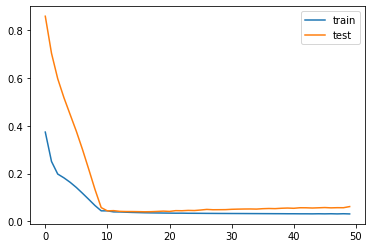

Test RMSE: 0.077


In [133]:
# split into train and test sets
values = reframed.values
n_train_months = 10 * 12
train = values[:n_train_months, :]
test = values[n_train_months:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

# design network
model = Sequential()
model.add(LSTM(25, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(5))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=10, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

The 'projections.csv' file has projections for unemployment, income, population and interest rates. Actual values were included when available. Projections for unemployment and interest rates where held at the same values as the last actual values available. Income and population were projected based on the trend of the past five years.

In [168]:
projections_df = pd.read_csv('projections.csv')
projections_df.head()

,Date,Price,Unemployment,Income,Population,Interest
0,1/31/20,310000,2.7,83768,2053000,3.62
1,2/29/20,325000,2.6,83768,2053000,3.47
2,3/31/20,335000,3.8,83768,2053000,3.45
3,4/30/20,330000,11.8,83768,2053000,3.31
4,5/31/20,332250,10.4,83768,2053000,3.23


In [169]:
projections_df['Date'] = pd.to_datetime(projections_df['Date'])
projections_df.set_index('Date', inplace=True)

projections_values = projections_df.values
# ensure all data is float
projections_values = projections_values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
projections_scaled = scaler.fit_transform(projections_values)
# frame as supervised learning
projections_reframed = series_to_supervised(projections_scaled, 1, 1)
# drop columns we don't want to predict
projections_reframed.drop(projections_reframed.columns[[6, 7, 8, 9]], axis=1, inplace=True)
print(projections_reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)   var1(t)
1   0.000000   0.010870        0.0        0.0   1.000000  0.037485
2   0.037485   0.000000        0.0        0.0   0.840426  0.062474
3   0.062474   0.130435        0.0        0.0   0.819149  0.049979
4   0.049979   1.000000        0.0        0.0   0.670213  0.055602
5   0.055602   0.847826        0.0        0.0   0.585107  0.087464


(142, 1, 5) (142,) (35, 1, 5) (35,)
Train on 142 samples, validate on 35 samples
Epoch 1/50
 - 7s - loss: 0.4151 - val_loss: 0.4552
Epoch 2/50
 - 0s - loss: 0.4028 - val_loss: 0.4423
Epoch 3/50
 - 0s - loss: 0.3898 - val_loss: 0.4293
Epoch 4/50
 - 0s - loss: 0.3770 - val_loss: 0.4163
Epoch 5/50
 - 0s - loss: 0.3643 - val_loss: 0.4031
Epoch 6/50
 - 0s - loss: 0.3518 - val_loss: 0.3897
Epoch 7/50
 - 0s - loss: 0.3396 - val_loss: 0.3769
Epoch 8/50
 - 0s - loss: 0.3279 - val_loss: 0.3647
Epoch 9/50
 - 0s - loss: 0.3164 - val_loss: 0.3524
Epoch 10/50
 - 0s - loss: 0.3053 - val_loss: 0.3413
Epoch 11/50
 - 0s - loss: 0.2953 - val_loss: 0.3300
Epoch 12/50
 - 0s - loss: 0.2858 - val_loss: 0.3187
Epoch 13/50
 - 0s - loss: 0.2773 - val_loss: 0.3084
Epoch 14/50
 - 0s - loss: 0.2696 - val_loss: 0.2983
Epoch 15/50
 - 0s - loss: 0.2626 - val_loss: 0.2884
Epoch 16/50
 - 0s - loss: 0.2560 - val_loss: 0.2790
Epoch 17/50
 - 0s - loss: 0.2498 - val_loss: 0.2697
Epoch 18/50
 - 0s - loss: 0.2439 - val_loss:

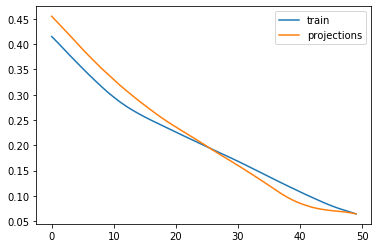

Test RMSE: 31300.041


In [170]:
# split into train and test sets
values = reframed.values
n_train_months = 10 * 12
train = values[:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))

# split into train and test sets
projections_values = projections_reframed.values
test = projections_values[:, :]
# split into input and outputs
projections_X, projections_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
projections_X = projections_X.reshape((projections_X.shape[0], 1, projections_X.shape[1]))
print(train_X.shape, train_y.shape, projections_X.shape, projections_y.shape)


# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(5))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(projections_X, projections_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='projections')
pyplot.legend()
pyplot.show()

# make a prediction
yhat = model.predict(projections_X)
projections_X = projections_X.reshape((projections_X.shape[0], projections_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, projections_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

# invert scaling for actual
projections_y = projections_y.reshape((len(projections_y), 1))
inv_y = concatenate((projections_y, projections_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

A list of the predicted home prices.

In [171]:
inv_yhat

array([368992.94, 375053.06, 375040.2 , 354265.84, 359733.03, 368597.47,
       375926.53, 382303.  , 382411.94, 388305.62, 388649.4 , 392133.66,
       483135.38, 490461.7 , 498701.66, 512969.22, 516608.03, 519413.97,
       522276.62, 525196.9 , 528176.06, 531215.4 , 534315.3 , 537477.3 ,
       642589.4 , 645966.3 , 649406.3 , 652909.8 , 656478.3 , 660112.2 ,
       663812.3 , 667579.5 , 671414.94, 675319.25, 679293.2 ],
      dtype=float32)

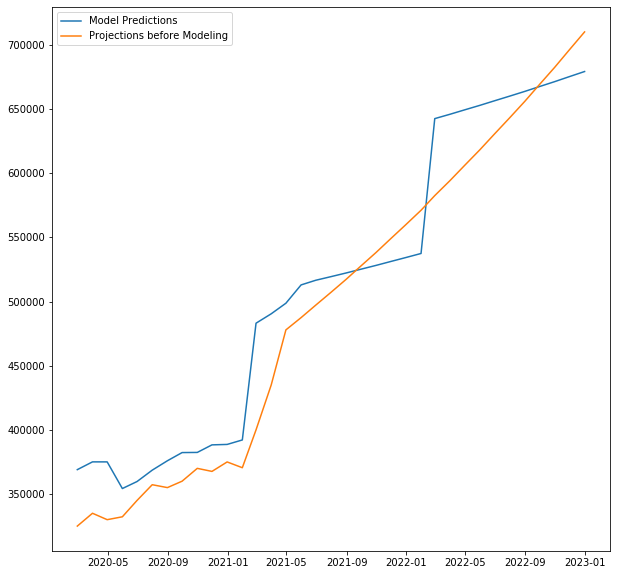

In [172]:
f = pyplot.figure()
f.set_figwidth(10)
f.set_figheight(10)
pyplot.plot(projections_df.index[1:], inv_yhat, label='Model Predictions')
pyplot.plot(projections_df.index[1:], projections_df['Price'][1:], label='Projections before Modeling')

# pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()
